# Import Data

In [1]:
# clear memory
%reset -f

# helper.py
from helper import *

In [2]:
# load data
df = pd.read_csv('./data/clean/master.csv')

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

################################################################################## Take this code out after getting the 2024 PFF data
# drop 2024 rows
players_2024 = df[df['Year'] == 2024]
df = df[df['Year'] != 2024]
##################################################################################

# show shape and nulls
show_shape_and_nulls(df)

Shape: (28740, 64)
Null values:


,Player,Tm,Pos,Age,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Scrim_TD,Key,Year,Pass_Y/A,Scrim_Yds,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,Touches,Pass_Cmp%,Rec_Catch%,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,Rec_TD_per_game,Fmb_per_game,FmbLost_per_game,Scrim_TD_per_game,Scrim_Yds_per_game,Touches_per_game,Points_half-ppr,PPG_half-ppr,PPT_half-ppr,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr,Points_VORP_half-ppr,PPG_VORP_half-ppr,PointsTarget_half-ppr,PPGTarget_half-ppr
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6330,6330


- The only null values are held in the "Target" columns (indicating players in their final season). We cannot use rows without a target to train, so they will be dropped here.
- We will be using __Seasonal half-ppr fantasy points__ as the target. Using PPG is possible, but this would not punish players for missing games or getting injured (which is unfortunate but very common in the NFL).

In [3]:
# drop target cols
df = df.drop(columns=[col for col in df.columns if 'Target' in col and col != 'PointsTarget_half-ppr'])

# drop players with null Target values
df = df.dropna(subset='PointsTarget_half-ppr')

# check
df.isna().sum().sum()

0

# Create Features

In [4]:
def create_features(df):
    """
    Create features for each player.

    Args:
    - df (pd.dataframe): Contains the 

    Returns:
    - (pl.dataframe): Dataframe with new features added.
    """

    # convert to polars dataframe and sort
    df = pl.from_pandas(df).sort(["Key", "Year"])

    # define cols to aggregate
    non_feat_cols = ['Player', 'Tm', 'Pos', 'Key', 'Year', 'PointsTarget_half-ppr']
    non_agg_cols = ['Age', 'num_games', 'Exp']
    agg_cols = [col for col in df.columns if col not in non_agg_cols + non_feat_cols]

    # define mean/std functions for 3-year and total career
    windows = {
        '3yr_mean': lambda col: pl.col(col).rolling_mean(window_size=3, min_periods=1).sort_by('Year').over('Key'),
        '3yr_std': lambda col: pl.col(col).rolling_std(window_size=3, min_periods=1).sort_by('Year').over('Key').fill_nan(0),
        'career_mean': lambda col: (pl.col(col).cum_sum().over('Key') / (pl.col(col).cum_count().sort_by('Year').over('Key')))}

    # convert to a lazy frame for efficiency
    lazy_df = df.lazy()

    # build a list of new expressions for the aggregated features
    new_exprs = []
    for win_name, func in windows.items():
        for col in agg_cols:
            new_col_name = f"{col}_{win_name}"
            new_exprs.append(func(col).alias(new_col_name))

    # add the new columns to the DataFrame
    lazy_df = lazy_df.with_columns(new_exprs)

    # sort columns
    lazy_df = lazy_df.select(sorted(lazy_df.columns))

    # collect the results back into a pandas DataFrame
    return lazy_df.collect().to_pandas()

In [5]:
# aggregate data by player
df = create_features(df)

# fill nulls and infinities
df = df.fillna(0)
df = df.replace([np.inf, -np.inf], 0)

# check
df.sample()

,Age,AllPro,AllPro_3yr_mean,AllPro_3yr_std,AllPro_career_mean,Exp,Fmb,FmbLost,FmbLost_3yr_mean,FmbLost_3yr_std,FmbLost_career_mean,FmbLost_per_game,FmbLost_per_game_3yr_mean,FmbLost_per_game_3yr_std,FmbLost_per_game_career_mean,Fmb_3yr_mean,Fmb_3yr_std,Fmb_career_mean,Fmb_per_game,Fmb_per_game_3yr_mean,Fmb_per_game_3yr_std,Fmb_per_game_career_mean,Key,PPGOvrRank_half-ppr,PPGOvrRank_half-ppr_3yr_mean,PPGOvrRank_half-ppr_3yr_std,PPGOvrRank_half-ppr_career_mean,PPGPosRank_half-ppr,PPGPosRank_half-ppr_3yr_mean,PPGPosRank_half-ppr_3yr_std,PPGPosRank_half-ppr_career_mean,PPG_VORP_half-ppr,PPG_VORP_half-ppr_3yr_mean,PPG_VORP_half-ppr_3yr_std,PPG_VORP_half-ppr_career_mean,PPG_half-ppr,PPG_half-ppr_3yr_mean,PPG_half-ppr_3yr_std,PPG_half-ppr_career_mean,PPTOvrRank_half-ppr,PPTOvrRank_half-ppr_3yr_mean,PPTOvrRank_half-ppr_3yr_std,PPTOvrRank_half-ppr_career_mean,PPTPosRank_half-ppr,PPTPosRank_half-ppr_3yr_mean,PPTPosRank_half-ppr_3yr_std,PPTPosRank_half-ppr_career_mean,PPT_half-ppr,PPT_half-ppr_3yr_mean,PPT_half-ppr_3yr_std,PPT_half-ppr_career_mean,Pass_Att,Pass_Att_3yr_mean,Pass_Att_3yr_std,Pass_Att_career_mean,Pass_Att_per_game,Pass_Att_per_game_3yr_mean,Pass_Att_per_game_3yr_std,Pass_Att_per_game_career_mean,Pass_Cmp,Pass_Cmp%,Pass_Cmp%_3yr_mean,Pass_Cmp%_3yr_std,Pass_Cmp%_career_mean,Pass_Cmp_3yr_mean,Pass_Cmp_3yr_std,Pass_Cmp_career_mean,Pass_Cmp_per_game,Pass_Cmp_per_game_3yr_mean,Pass_Cmp_per_game_3yr_std,Pass_Cmp_per_game_career_mean,Pass_Int,Pass_Int_3yr_mean,Pass_Int_3yr_std,Pass_Int_career_mean,Pass_Int_per_game,Pass_Int_per_game_3yr_mean,Pass_Int_per_game_3yr_std,Pass_Int_per_game_career_mean,Pass_TD,Pass_TD_3yr_mean,Pass_TD_3yr_std,Pass_TD_career_mean,Pass_TD_per_game,Pass_TD_per_game_3yr_mean,Pass_TD_per_game_3yr_std,Pass_TD_per_game_career_mean,Pass_Y/A,Pass_Y/A_3yr_mean,Pass_Y/A_3yr_std,Pass_Y/A_career_mean,Pass_Yds,Pass_Yds_3yr_mean,Pass_Yds_3yr_std,Pass_Yds_career_mean,Pass_Yds_per_game,Pass_Yds_per_game_3yr_mean,Pass_Yds_per_game_3yr_std,Pass_Yds_per_game_career_mean,Player,PointsOvrRank_half-ppr,PointsOvrRank_half-ppr_3yr_mean,PointsOvrRank_half-ppr_3yr_std,PointsOvrRank_half-ppr_career_mean,PointsPosRank_half-ppr,PointsPosRank_half-ppr_3yr_mean,PointsPosRank_half-ppr_3yr_std,PointsPosRank_half-ppr_career_mean,PointsTarget_half-ppr,Points_VORP_half-ppr,Points_VORP_half-ppr_3yr_mean,Points_VORP_half-ppr_3yr_std,Points_VORP_half-ppr_career_mean,Points_half-ppr,Points_half-ppr_3yr_mean,Points_half-ppr_3yr_std,Points_half-ppr_career_mean,Pos,ProBowl,ProBowl_3yr_mean,ProBowl_3yr_std,ProBowl_career_mean,Rec_Catch%,Rec_Catch%_3yr_mean,Rec_Catch%_3yr_std,Rec_Catch%_career_mean,Rec_Rec,Rec_Rec_3yr_mean,Rec_Rec_3yr_std,Rec_Rec_career_mean,Rec_Rec_per_game,Rec_Rec_per_game_3yr_mean,Rec_Rec_per_game_3yr_std,Rec_Rec_per_game_career_mean,Rec_TD,Rec_TD_3yr_mean,Rec_TD_3yr_std,Rec_TD_career_mean,Rec_TD_per_game,Rec_TD_per_game_3yr_mean,Rec_TD_per_game_3yr_std,Rec_TD_per_game_career_mean,Rec_Tgt,Rec_Tgt_3yr_mean,Rec_Tgt_3yr_std,Rec_Tgt_career_mean,Rec_Tgt_per_game,Rec_Tgt_per_game_3yr_mean,Rec_Tgt_per_game_3yr_std,Rec_Tgt_per_game_career_mean,Rec_Y/R,Rec_Y/R_3yr_mean,Rec_Y/R_3yr_std,Rec_Y/R_career_mean,Rec_Yds,Rec_Yds_3yr_mean,Rec_Yds_3yr_std,Rec_Yds_career_mean,Rec_Yds_per_game,Rec_Yds_per_game_3yr_mean,Rec_Yds_per_game_3yr_std,Rec_Yds_per_game_career_mean,Rush_Att,Rush_Att_3yr_mean,Rush_Att_3yr_std,Rush_Att_career_mean,Rush_Att_per_game,Rush_Att_per_game_3yr_mean,Rush_Att_per_game_3yr_std,Rush_Att_per_game_career_mean,Rush_TD,Rush_TD_3yr_mean,Rush_TD_3yr_std,Rush_TD_career_mean,Rush_TD_per_game,Rush_TD_per_game_3yr_mean,Rush_TD_per_game_3yr_std,Rush_TD_per_game_career_mean,Rush_Y/A,Rush_Y/A_3yr_mean,Rush_Y/A_3yr_std,Rush_Y/A_career_mean,Rush_Yds,Rush_Yds_3yr_mean,Rush_Yds_3yr_std,Rush_Yds_career_mean,Rush_Yds_per_game,Rush_Yds_per_game_3yr_mean,Rush_Yds_per_game_3yr_std,Rush_Yds_per_game_career_mean,Scrim_TD,Scrim_TD_3yr_mean,Scrim_TD_3yr_std,Scrim_TD_career_mean,Scrim_TD_per_game,Scrim_TD_per_game_3yr_mean,Scrim_TD_per_game_3yr_std,

# Positional Subsets

In [6]:
# turn 'Pos' column into 4 categorical columns
df = pd.get_dummies(df, columns=['Pos'])

# create the 4 positional subsets
qb = df.query('Pos_QB == 1')
rb = df.query('Pos_RB == 1')
wr = df.query('Pos_WR == 1')
te = df.query('Pos_TE == 1')

# drop positional columns
pos_cols = ['Pos_QB', 'Pos_RB', 'Pos_WR', 'Pos_TE']
for pos in [qb, rb, wr, te]:
    pos = pos.drop(columns=pos_cols)

# drop 'Rec' cols for QBs
rec_cols = [col for col in df.columns if col.startswith('Rec_')]
qb = qb.drop(columns=rec_cols)

# drop 'Pass' cols for RBs, WRs, and TEs
pass_cols = [col for col in df.columns if col.startswith('Pass_')]
for pos in [rb, wr, te]:
    pos = pos.drop(columns=pass_cols)

# show shapes
qb.shape, rb.shape, wr.shape, te.shape

((3458, 188), (7089, 228), (7555, 228), (4308, 228))

- 188 features for the QB subset
- 228 features for the other 3 subsets

# Test Models

In [8]:
# define models and scalers
models = [LinearRegression(n_jobs=-1), RandomForestRegressor(n_jobs=-1, random_state=SEED), XGBRegressor(n_jobs=-1, random_state=SEED)]
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# create a df to hold model performance
models_df = pd.DataFrame(columns=['Model', 'Scaler', 'Train_RMSE', 'Val_RMSE', 'Train_R2', 'Val_R2']).astype({
    'Model': 'object', 'Scaler': 'object', 'Train_RMSE': 'float', 'Val_RMSE': 'float', 'Train_R2': 'float', 'Val_R2': 'float'})
models_df

,Model,Scaler,Train_RMSE,Val_RMSE,Train_R2,Val_R2


In [ ]:
def cross_val_model(estimator, df, scaler, models_df, folds=5):
    """
    Perform KFold cross validation on a given estimator and store evaluation metrics.
    
    Args:
    - estimator (sklearn estimator): Estimator to use for modeling.
    - df (pd.DataFrame): Data to model.
    - scaler (sklearn scaler, optional): Scaler to use for data.
    - models_df (pd.DataFrame): DataFrame to save model results to. Expected columns: ['Model', 'Scaler', 'Train_RMSE', 'Val_RMSE', 'Train_R2', 'Val_R2']
    - folds (int): Number of cross-validation folds to use. Default is 5.
    
    Returns:
    - models_df (pd.DataFrame): Updated DataFrame with a new row containing model evaluation metrics.
    """

    # define the pipeline
    pipeline = Pipeline(steps=[('scaler', scaler), ('model', estimator)])

    # non feature cols
    non_feat_cols = ['Player', 'Tm', 'Key', 'Year', 'PointsTarget_half-ppr']

    # define x and y
    X = df.drop(non_feat_cols, axis=1)
    y = df['PointsTarget_half-ppr']

    # init lists to store metrics across folds
    train_rmse_list, val_rmse_list = [], []
    train_r2_list, val_r2_list = [], []
    
    # iterate through k-folds
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)
    for train_index, val_index in kf.split(X):
        # split X and y
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # predict on train and validation sets
        y_train_pred = pipeline.predict(X_train)
        y_val_pred = pipeline.predict(X_val)
        
        # rmse
        train_rmse = root_mean_squared_error(y_train, y_train_pred)
        val_rmse = root_mean_squared_error(y_val, y_val_pred)

        # r^2
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        
        # append metrics for this fold
        train_rmse_list.append(train_rmse)
        val_rmse_list.append(val_rmse)
        train_r2_list.append(train_r2)
        val_r2_list.append(val_r2)
    
    # prepare a new row with averages
    new_row = {
        'Model': estimator.__class__.__name__,
        'Scaler': scaler.__class__.__name__,
        'Train_RMSE': np.mean(train_rmse_list),
        'Val_RMSE': np.mean(val_rmse_list),
        'Train_R2': np.mean(train_r2_list),
        'Val_R2': np.mean(val_r2_list)
    }

    # append the new row
    models_df.loc[len(models_df)] = new_row

In [11]:
# run models
for model in tqdm(models, desc="Running Models"):
    for scaler in scalers:
        cross_val_model(estimator=model, df=qb, scaler=scaler, models_df=models_df)

Running Models: 100%|██████████| 3/3 [02:41<00:00, 54.00s/it]


In [13]:
# save models_df
models_df.to_csv('models_df.csv', index=False)

# inspect
models_df.sort_values(by='Val_RMSE').head(10)

,Model,Scaler,Train_RMSE,Val_RMSE,Train_R2,Val_R2
4,RandomForestRegressor,MinMaxScaler,26.132290,69.863625,0.931123,0.503653
5,RandomForestRegressor,RobustScaler,26.125918,69.910687,0.931157,0.503012
3,RandomForestRegressor,StandardScaler,26.132204,69.920236,0.931124,0.502858
0,LinearRegression,StandardScaler,66.535401,70.873390,0.553512,0.489611
2,LinearRegression,RobustScaler,66.535401,70.873390,0.553512,0.489611
1,LinearRegression,MinMaxScaler,66.535401,70.873390,0.553512,0.489611
6,XGBRegressor,StandardScaler,6.803175,73.383687,0.995319,0.453387
7,XGBRegressor,MinMaxScaler,7.462457,73.645581,0.994362,0.449250
8,XGBRegressor,RobustScaler,6.990391,74.038791,0.995065,0.442806


QB - Higher Scoring Players - RMSE: 6.00, R-squared: -4.08
QB - Lower Scoring Players - RMSE: 5.10, R-squared: 0.12


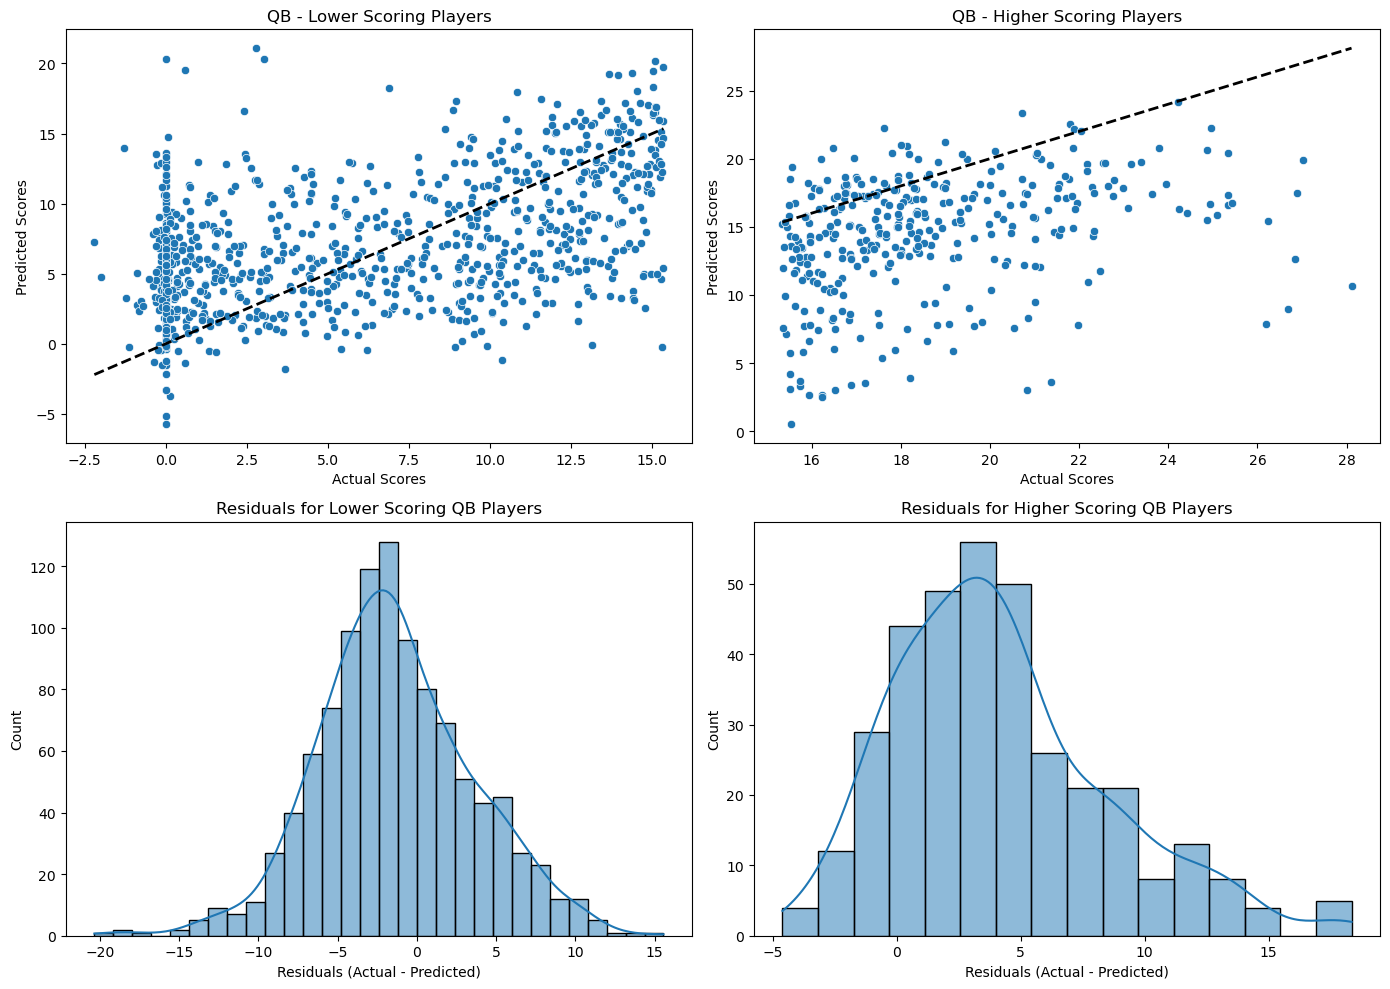

In [9]:
# create pipeline
scaler = RobustScaler()
lr = LinearRegression()
pipeline = Pipeline([
    ('scaler', scaler),
    ('estimator', lr)
])

# Add predictions to the DataFrame
qb['y_pred'] = cross_val_predict(pipeline, X, y, cv=5, n_jobs=-1)

# Add target_rank and pred_rank columns
qb['target_rank'] = qb.groupby(['Year'])['PPGTarget_half-ppr'].rank(ascending=False, method='min')
qb['pred_rank'] = qb.groupby(['Year'])['y_pred'].rank(ascending=False, method='min')

# Function to plot positional group
def plot_positional_group(position_df, position_name):
    # define threshold to get top 25% of players
    threshold = position_df['PPGTarget_half-ppr'].quantile(0.75)

    # Split the data into higher and lower scoring players
    higher_scoring = position_df[position_df['PPGTarget_half-ppr'] >= threshold]
    lower_scoring = position_df[position_df['PPGTarget_half-ppr'] < threshold]

    # Higher scoring players
    higher_rmse = mean_squared_error(higher_scoring['PPGTarget_half-ppr'], higher_scoring['y_pred'], squared=False)
    higher_r2 = r2_score(higher_scoring['PPGTarget_half-ppr'], higher_scoring['y_pred'])

    # Lower scoring players
    lower_rmse = mean_squared_error(lower_scoring['PPGTarget_half-ppr'], lower_scoring['y_pred'], squared=False)
    lower_r2 = r2_score(lower_scoring['PPGTarget_half-ppr'], lower_scoring['y_pred'])

    print(f'{position_name} - Higher Scoring Players - RMSE: {higher_rmse:.2f}, R-squared: {higher_r2:.2f}')
    print(f'{position_name} - Lower Scoring Players - RMSE: {lower_rmse:.2f}, R-squared: {lower_r2:.2f}')

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Scatter plot for lower scoring players
    sns.scatterplot(x=lower_scoring['PPGTarget_half-ppr'], y=lower_scoring['y_pred'], ax=axes[0, 0])
    axes[0, 0].plot([lower_scoring['PPGTarget_half-ppr'].min(), lower_scoring['PPGTarget_half-ppr'].max()], 
                    [lower_scoring['PPGTarget_half-ppr'].min(), lower_scoring['PPGTarget_half-ppr'].max()], 'k--', lw=2)
    axes[0, 0].set_title(f'{position_name} - Lower Scoring Players')
    axes[0, 0].set_xlabel('Actual Scores')
    axes[0, 0].set_ylabel('Predicted Scores')

    # Scatter plot for higher scoring players
    sns.scatterplot(x=higher_scoring['PPGTarget_half-ppr'], y=higher_scoring['y_pred'], ax=axes[0, 1])
    axes[0, 1].plot([higher_scoring['PPGTarget_half-ppr'].min(), higher_scoring['PPGTarget_half-ppr'].max()], 
                    [higher_scoring['PPGTarget_half-ppr'].min(), higher_scoring['PPGTarget_half-ppr'].max()], 'k--', lw=2)
    axes[0, 1].set_title(f'{position_name} - Higher Scoring Players')
    axes[0, 1].set_xlabel('Actual Scores')
    axes[0, 1].set_ylabel('Predicted Scores')

    # Distribution of residuals for lower scoring players
    sns.histplot(lower_scoring['PPGTarget_half-ppr'] - lower_scoring['y_pred'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Residuals for Lower Scoring {position_name} Players')
    axes[1, 0].set_xlabel('Residuals (Actual - Predicted)')

    # Distribution of residuals for higher scoring players
    sns.histplot(higher_scoring['PPGTarget_half-ppr'] - higher_scoring['y_pred'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Residuals for Higher Scoring {position_name} Players')
    axes[1, 1].set_xlabel('Residuals (Actual - Predicted)')

    plt.tight_layout()
    plt.show()

# Apply the function to each positional group
plot_positional_group(qb, 'QB')

In [11]:

# Calculate rank difference
qb['rank_diff'] = qb['target_rank'] - qb['pred_rank']

# Function to get top 10 players for each year and position based on actual and predicted ranks
def get_top_10_players(df):
    results = []

    for year in df['Year'].unique():
        actual_top_10 = df[df['Year'] == year].nsmallest(10, 'target_rank')
        predicted_top_10 = df[df['Year'] == year].nsmallest(10, 'pred_rank')

        results.append({
            'Year': year,
            'Actual_Top_10': actual_top_10[['Player', 'PPGTarget_half-ppr', 'target_rank']].reset_index(drop=True),
            'Predicted_Top_10': predicted_top_10[['Player', 'y_pred', 'pred_rank']].reset_index(drop=True)
        })
    
    return results

# Apply the function to each positional group
qb_top_10 = get_top_10_players(qb)

# Function to display the results
def display_top_10(results):
    for result in results:
        print(f"Year: {result['Year']}")
        print("Actual Top 10:")
        print(result['Actual_Top_10'])
        print("\nPredicted Top 10:")
        print(result['Predicted_Top_10'])
        print("\n" + "="*50 + "\n")

# Display the results for each positional group
display_top_10(qb_top_10)

Year: 2019
Actual Top 10:
            Player  PPGTarget_half-ppr  target_rank
0     Dak Prescott            27.02800          1.0
1   Marcus Mariota            26.84000          2.0
2       Josh Allen            25.34750          3.0
3  Patrick Mahomes            24.96000          4.0
4     Kyler Murray            24.42125          5.0
5    Aaron Rodgers            24.23500          6.0
6   Deshaun Watson            23.39500          7.0
7   Russell Wilson            23.17375          8.0
8    Lamar Jackson            22.65200          9.0
9        Tom Brady            21.87000         10.0

Predicted Top 10:
            Player     y_pred  pred_rank
0  Patrick Mahomes  22.228587        1.0
1     Dak Prescott  19.879454        2.0
2   Deshaun Watson  19.719067        3.0
3   Russell Wilson  19.595842        4.0
4   Jameis Winston  19.510826        5.0
5    Lamar Jackson  17.977719        6.0
6  Jimmy Garoppolo  17.434949        7.0
7       Josh Allen  17.352537        8.0
8     Carson W

Use 2024 projection data, calculate VORP. 